# Sentiment Topic Analysis EDA

## Overview
This notebook performs exploratory data analysis on sentiment and topic data for various companies. The main objectives are:

1. **15x15 Heatmap Visualization**: Display sentiment scores as a 15x15 image where:
   - **X-axis**: Days (15-day period)
   - **Y-axis**: Topics (15 topics with human-readable names)
   - **Values**: Sentiment scores (-1 to +1) represented as pixel intensities

2. **Topic Correlation Analysis**: Analyze correlations between topics based on their sentiment patterns over time

3. **Topic Sentiment Distribution Analysis**: For each company, analyze the distribution of sentiments across topics to identify most positive, negative, and polarized topics

## Data Structure
- **Source**: GDELT news data with sentiment analysis and topic modeling
- **Files per company**: 
  - `headline_topics.csv`: Topic assignments for each headline
  - `headline_sentiments.csv`: Sentiment scores for each headline
  - `topic_names.json`: Human-readable topic descriptions
  - `gdelt_{company}.csv`: Original headlines with dates

## 1. Setup and Data Discovery

In [25]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [26]:
# Define data paths
CLEANED_DATA_PATH = r"C:\Users\KemalUtkuLekesiz\Documents\Kod\Okul\NLP\SentimTA\data_sentim\cleaned"

# Discover available sentiment folders
sentiment_folders = [f for f in os.listdir(CLEANED_DATA_PATH) 
                    if f.startswith("sentiment_gdelt_") and os.path.isdir(os.path.join(CLEANED_DATA_PATH, f))]

# Extract company names
companies = []
for folder in sentiment_folders:
    if folder.endswith('_20170101_to_20241231'):
        company = folder.replace('sentiment_gdelt_', '').replace('_20170101_to_20241231', '')
        companies.append(company)

print(f"📊 Found {len(companies)} companies with sentiment data:")
print(f"   {', '.join(companies[:10])}{'...' if len(companies) > 10 else ''}")
print(f"\n🗂️  Sample companies for analysis: {companies[:5]}")

📊 Found 25 companies with sentiment data:
   3m, amazon, american_express, amgen, apple, boeing, caterpillar, chevron, cisco_systems, disney...

🗂️  Sample companies for analysis: ['3m', 'amazon', 'american_express', 'amgen', 'apple']


## 2. Core Functions

In [27]:
def load_company_data(company_name):
    """
    Load and merge sentiment, topic, and date data for a company.
    
    Args:
        company_name (str): Company name (e.g., 'apple', 'microsoft')
        
    Returns:
        tuple: (merged_dataframe, topic_names_dict) or (None, None) if error
    """
    try:
        # Define paths
        folder_name = f"sentiment_gdelt_{company_name}_20170101_to_20241231"
        sentiment_folder = os.path.join(CLEANED_DATA_PATH, folder_name)
        original_data_path = os.path.join(CLEANED_DATA_PATH, f"gdelt_{company_name}.csv")
        
        # Load datasets
        print(f"📈 Loading data for {company_name.title()}...")
        
        # Original data with dates
        original_df = pd.read_csv(original_data_path)
        original_df['Date'] = pd.to_datetime(original_df['Date'])
        
        # Topic and sentiment data
        topics_df = pd.read_csv(os.path.join(sentiment_folder, "headline_topics.csv"))
        sentiments_df = pd.read_csv(os.path.join(sentiment_folder, "headline_sentiments.csv"))
        
        # Topic names for better visualization
        topic_names_path = os.path.join(sentiment_folder, "topic_names.json")
        topic_names = {}
        if os.path.exists(topic_names_path):
            with open(topic_names_path, 'r') as f:
                topic_names = json.load(f)
        
        # Normalize headlines for matching (case-insensitive, whitespace-trimmed)
        original_df['headline_norm'] = original_df['Headline'].str.lower().str.strip()
        topics_df['headline_norm'] = topics_df['headline'].str.lower().str.strip()
        sentiments_df['headline_norm'] = sentiments_df['headline'].str.lower().str.strip()
        
        # Merge datasets
        merged = original_df.merge(topics_df, on='headline_norm', how='inner')
        merged = merged.merge(sentiments_df, on='headline_norm', how='inner')
        
        # Clean up columns
        merged = merged.drop(['headline_x', 'headline_y', 'headline_norm'], axis=1, errors='ignore')
        merged = merged.rename(columns={'Headline': 'headline'})
        
        print(f"   ✅ Loaded {len(merged):,} records from {merged['Date'].min().date()} to {merged['Date'].max().date()}")
        print(f"   📊 Topics: {merged['topic_id'].nunique()} | Sentiment range: [{merged['sentiment'].min():.2f}, {merged['sentiment'].max():.2f}]")
        
        return merged, topic_names
        
    except Exception as e:
        print(f"   ❌ Error loading {company_name}: {str(e)}")
        return None, None

In [28]:
def create_sentiment_heatmap(company_name, random_seed=None, days_back=15):
    """
    Create a sentiment heatmap showing topics vs days as a 15x15 image.
    
    Args:
        company_name (str): Company to analyze
        random_seed (int): Seed for random date selection
        days_back (int): Number of days to analyze (default: 15)
        
    Returns:
        dict: Analysis results including figure, dates, and data
    """
    if random_seed:
        random.seed(random_seed)
        np.random.seed(random_seed)
    
    # Load data
    df, topic_names = load_company_data(company_name)
    if df is None:
        return None
    
    # Select random date period
    unique_dates = df['Date'].dt.date.unique()
    min_valid_date = df['Date'].min().date() + timedelta(days=days_back-1)
    valid_dates = [d for d in unique_dates if d >= min_valid_date]
    
    if not valid_dates:
        print(f"❌ Not enough data for {days_back}-day analysis")
        return None
    
    end_date = random.choice(valid_dates)
    start_date = end_date - timedelta(days=days_back-1)
    
    print(f"\n🎯 Analysis Period: {start_date} to {end_date} ({days_back} days)")
    
    # Filter data for the period
    period_data = df[(df['Date'].dt.date >= start_date) & (df['Date'].dt.date <= end_date)].copy()
    
    if len(period_data) == 0:
        print(f"❌ No data found for selected period")
        return None
    
    print(f"📊 Found {len(period_data):,} headlines in the period")
    
    # Get topics (should be 0-14 for all companies)
    unique_topics = sorted(period_data['topic_id'].unique())
    num_topics = len(unique_topics)
    
    # Create date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize sentiment matrix: Topics (rows) x Days (columns)
    sentiment_matrix = np.zeros((num_topics, days_back))
    
    # Fill matrix with average daily sentiment per topic
    for day_idx, date in enumerate(date_range):
        day_data = period_data[period_data['Date'].dt.date == date.date()]
        
        for topic_idx, topic_id in enumerate(unique_topics):
            topic_data = day_data[day_data['topic_id'] == topic_id]
            
            if len(topic_data) > 0:
                sentiment_matrix[topic_idx, day_idx] = topic_data['sentiment'].mean()
            # else: remains 0 (neutral)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(14, max(8, num_topics * 0.5)))
    
    # Create heatmap
    im = ax.imshow(sentiment_matrix, 
                   cmap='RdYlGn',  # Red=negative, Yellow=neutral, Green=positive
                   aspect='auto', 
                   vmin=-1, vmax=1,
                   interpolation='nearest')
    
    # Customize axes
    ax.set_title(f'Sentiment Heatmap: {company_name.title()}\n'
                f'Period: {start_date} to {end_date}', 
                fontsize=16, fontweight='bold', pad=20)
    
    # X-axis: Days
    ax.set_xlabel('Days', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(date_range)))
    ax.set_xticklabels([d.strftime('%m-%d') for d in date_range], rotation=45)
    
    # Y-axis: Topics with names
    ax.set_ylabel('Topics', fontsize=12, fontweight='bold')
    ax.set_yticks(range(num_topics))
    
    y_labels = []
    for topic_id in unique_topics:
        if topic_names and str(topic_id) in topic_names:
            name = topic_names[str(topic_id)]
            if len(name) > 25:
                name = name[:22] + "..."
            y_labels.append(f'T{topic_id}: {name}')
        else:
            y_labels.append(f'Topic {topic_id}')
    
    ax.set_yticklabels(y_labels, fontsize=9)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label('Sentiment Score', rotation=270, labelpad=20, fontweight='bold')
    
    # Add value annotations for better readability
    for i in range(num_topics):
        for j in range(days_back):
            value = sentiment_matrix[i, j]
            color = 'white' if abs(value) > 0.5 else 'black'
            ax.text(j, i, f'{value:.2f}', 
                   ha='center', va='center', 
                   color=color, fontsize=7, fontweight='bold')
    
    plt.tight_layout()
    
    # Return analysis results
    return {
        'figure': fig,
        'company': company_name,
        'start_date': start_date,
        'end_date': end_date,
        'sentiment_matrix': sentiment_matrix,
        'topics': unique_topics,
        'topic_names': topic_names,
        'data_points': len(period_data),
        'date_range': date_range
    }

In [29]:
def analyze_topic_correlations(analysis_result, show_heatmap=True, correlation_threshold=0.7):
    """
    Analyze correlations between topics based on sentiment patterns.
    
    Args:
        analysis_result (dict): Result from create_sentiment_heatmap
        show_heatmap (bool): Whether to display correlation heatmap
        correlation_threshold (float): Threshold for "high" correlations
        
    Returns:
        dict: Correlation analysis results
    """
    if not analysis_result:
        return None
    
    sentiment_matrix = analysis_result['sentiment_matrix']
    topics = analysis_result['topics']
    topic_names = analysis_result['topic_names']
    company = analysis_result['company']
    
    # Check topic variances and handle constant sentiment topics
    topic_variances = np.var(sentiment_matrix, axis=1)
    valid_mask = topic_variances > 1e-10
    
    print(f"\n🔍 Topic Variance Analysis:")
    for i, topic_id in enumerate(topics):
        variance = topic_variances[i]
        status = "✅ Variable" if variance > 1e-10 else "⚠️ Constant"
        avg_sentiment = np.mean(sentiment_matrix[i, :])
        print(f"   T{topic_id}: {status} (var={variance:.6f}, avg={avg_sentiment:.3f})")
    
    # Create full correlation matrix (including constant topics)
    # For constant topics, correlations will be NaN, which we'll handle
    correlation_matrix = np.full((len(topics), len(topics)), np.nan)
    
    # Calculate correlations only for variable topics
    if np.sum(valid_mask) >= 2:
        valid_indices = np.where(valid_mask)[0]
        valid_matrix = sentiment_matrix[valid_mask]
        valid_corr_matrix = np.corrcoef(valid_matrix)
        
        # Fill in the correlation matrix for valid topics
        for i, idx_i in enumerate(valid_indices):
            for j, idx_j in enumerate(valid_indices):
                correlation_matrix[idx_i, idx_j] = valid_corr_matrix[i, j]
    
    # Separate valid and excluded topics for reporting
    valid_topics = [topics[i] for i in range(len(topics)) if valid_mask[i]]
    excluded_topics = [topics[i] for i in range(len(topics)) if not valid_mask[i]]
    
    print(f"\n🔗 Topic Correlation Analysis: {company.title()}")
    print(f"   📊 Total topics: {len(topics)}")
    print(f"   📈 Variable topics: {len(valid_topics)}")
    if excluded_topics:
        print(f"   ⚠️  Constant sentiment topics: {excluded_topics}")
    
    # Find high correlations (only among variable topics)
    high_correlations = []
    if len(valid_topics) >= 2:
        for i in range(len(topics)):
            for j in range(i+1, len(topics)):
                if valid_mask[i] and valid_mask[j]:  # Both topics are variable
                    corr = correlation_matrix[i, j]
                    if not np.isnan(corr) and abs(corr) >= correlation_threshold:
                        topic1, topic2 = topics[i], topics[j]
                        name1 = topic_names.get(str(topic1), f"Topic {topic1}")
                        name2 = topic_names.get(str(topic2), f"Topic {topic2}")
                        
                        high_correlations.append({
                            'topic1': topic1, 'topic2': topic2,
                            'name1': name1, 'name2': name2,
                            'correlation': corr
                        })
    
    # Display high correlations
    if high_correlations:
        print(f"\n🎯 High Correlations (|r| ≥ {correlation_threshold}):")
        for corr_info in sorted(high_correlations, key=lambda x: abs(x['correlation']), reverse=True):
            corr_type = "📈 Positive" if corr_info['correlation'] > 0 else "📉 Negative"
            print(f"   {corr_type}: T{corr_info['topic1']} ↔ T{corr_info['topic2']} (r = {corr_info['correlation']:.3f})")
            print(f"     '{corr_info['name1']}' ↔ '{corr_info['name2']}'")
    else:
        print(f"\n📊 No high correlations found (threshold: {correlation_threshold})")
    
    # Overall statistics (only for variable topics)
    if len(valid_topics) > 1:
        # Extract only valid correlations (non-NaN, non-diagonal)
        valid_correlations = []
        for i in range(len(topics)):
            for j in range(i+1, len(topics)):
                if valid_mask[i] and valid_mask[j] and not np.isnan(correlation_matrix[i, j]):
                    valid_correlations.append(correlation_matrix[i, j])
        
        if valid_correlations:
            print(f"\n📈 Overall Correlation Statistics (variable topics only):")
            print(f"   Mean: {np.mean(valid_correlations):.3f}")
            print(f"   Std:  {np.std(valid_correlations):.3f}")
            print(f"   Max:  {np.max(valid_correlations):.3f}")
            print(f"   Min:  {np.min(valid_correlations):.3f}")
        else:
            print(f"\n📊 No valid correlations to compute statistics")
    else:
        print(f"\n📊 Insufficient variable topics for correlation statistics")
    
    # Visualization - Show ALL topics but mark constant ones differently
    if show_heatmap and len(topics) > 1:
        # Create topic labels for ALL topics
        labels = []
        for topic_id in topics:
            if topic_names and str(topic_id) in topic_names:
                name = topic_names[str(topic_id)]
                if len(name) > 20:
                    name = name[:17] + "..."
                label = f'T{topic_id}: {name}'
            else:
                label = f'T{topic_id}'
            
            # Mark constant topics
            if topic_id in excluded_topics:
                label += " (const)"
            
            labels.append(label)
        
        # Create correlation DataFrame with ALL topics
        corr_df = pd.DataFrame(correlation_matrix, index=labels, columns=labels)
        
        # Plot
        plt.figure(figsize=(max(10, len(topics) * 0.8), max(8, len(topics) * 0.7)))
        
        # Create a custom colormap that handles NaN values
        import matplotlib.patches as patches
        
        # Use the full correlation matrix (including NaN for constant topics)
        mask = np.triu(np.ones_like(correlation_matrix), k=1)
        
        # Create heatmap
        ax = sns.heatmap(corr_df, 
                        annot=True, 
                        cmap='RdBu_r', 
                        center=0,
                        square=True,
                        fmt='.2f',
                        cbar_kws={"shrink": .8, "label": "Correlation"},
                        mask=mask)
        
        # Add gray background for NaN (constant topics)
        for i in range(len(topics)):
            for j in range(len(topics)):
                if i != j and np.isnan(correlation_matrix[i, j]):
                    # Add gray rectangle for NaN values
                    rect = patches.Rectangle((j, i), 1, 1, linewidth=1, 
                                           edgecolor='gray', facecolor='lightgray', alpha=0.7)
                    ax.add_patch(rect)
        
        plt.title(f'Topic Correlation Matrix: {company.title()}\\n(Gray = Constant Sentiment Topics)', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Topics', fontsize=12, fontweight='bold')
        plt.ylabel('Topics', fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return {
        'correlation_matrix': correlation_matrix,
        'all_topics': topics,
        'valid_topics': valid_topics,
        'excluded_topics': excluded_topics,
        'high_correlations': high_correlations,
        'company': company,
        'period': f"{analysis_result['start_date']} to {analysis_result['end_date']}",
        'topic_variances': topic_variances
    }

## 3. Single Company Analysis

Let's start with analyzing a single company to understand the data structure and visualizations.

🍎 Analyzing Apple...
📈 Loading data for Apple...
   ✅ Loaded 21,851 records from 2017-01-15 to 2024-12-30
   📊 Topics: 15 | Sentiment range: [-1.00, 0.90]

🎯 Analysis Period: 2018-12-14 to 2018-12-28 (15 days)
📊 Found 136 headlines in the period


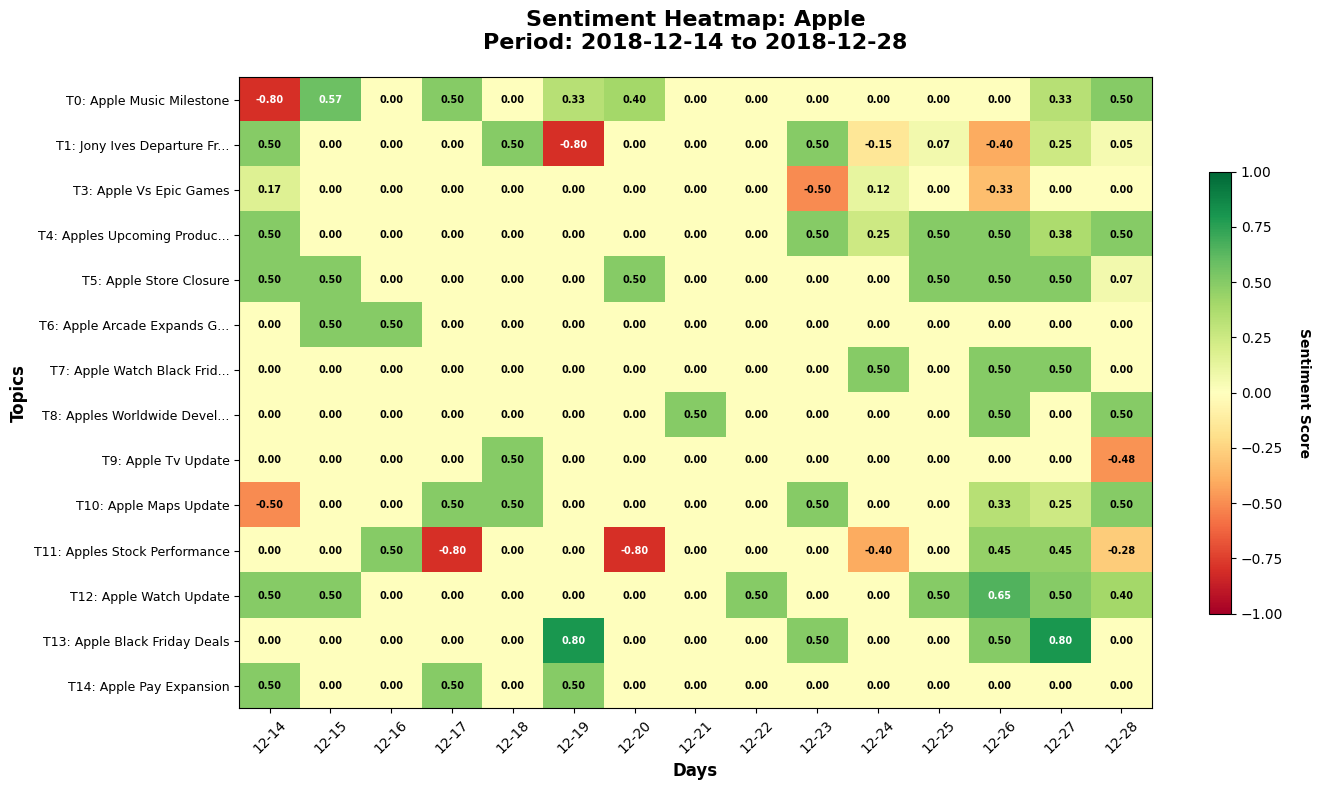


📊 Analysis Summary:
   Company: Apple
   Period: 2018-12-14 to 2018-12-28
   Headlines analyzed: 136
   Topics: 14 (0-14)
   Matrix shape: (14, 15) (Topics × Days)


In [30]:
# Analyze Apple as an example
company = "apple"
print(f"🍎 Analyzing {company.title()}...")

# Create sentiment heatmap
analysis = create_sentiment_heatmap(company, random_seed=42)

if analysis:
    plt.show()
    
    print(f"\n📊 Analysis Summary:")
    print(f"   Company: {analysis['company'].title()}")
    print(f"   Period: {analysis['start_date']} to {analysis['end_date']}")
    print(f"   Headlines analyzed: {analysis['data_points']:,}")
    print(f"   Topics: {len(analysis['topics'])} ({analysis['topics'][0]}-{analysis['topics'][-1]})")
    print(f"   Matrix shape: {analysis['sentiment_matrix'].shape} (Topics × Days)")
else:
    print("❌ Analysis failed")


🔍 Topic Variance Analysis:
   T0: ✅ Variable (var=0.108449, avg=0.123)
   T1: ✅ Variable (var=0.108277, avg=0.034)
   T3: ✅ Variable (var=0.025664, avg=-0.036)
   T4: ✅ Variable (var=0.053472, avg=0.208)
   T5: ✅ Variable (var=0.058499, avg=0.204)
   T6: ✅ Variable (var=0.028889, avg=0.067)
   T7: ✅ Variable (var=0.040000, avg=0.100)
   T8: ✅ Variable (var=0.040000, avg=0.100)
   T9: ✅ Variable (var=0.032025, avg=0.001)
   T10: ✅ Variable (var=0.075617, avg=0.139)
   T11: ✅ Variable (var=0.141452, avg=-0.059)
   T12: ✅ Variable (var=0.066156, avg=0.237)
   T13: ✅ Variable (var=0.088622, avg=0.173)
   T14: ✅ Variable (var=0.040000, avg=0.100)

🔗 Topic Correlation Analysis: Apple
   📊 Total topics: 14
   📈 Variable topics: 14

📊 No high correlations found (threshold: 0.7)

📈 Overall Correlation Statistics (variable topics only):
   Mean: -0.002
   Std:  0.253
   Max:  0.671
   Min:  -0.559


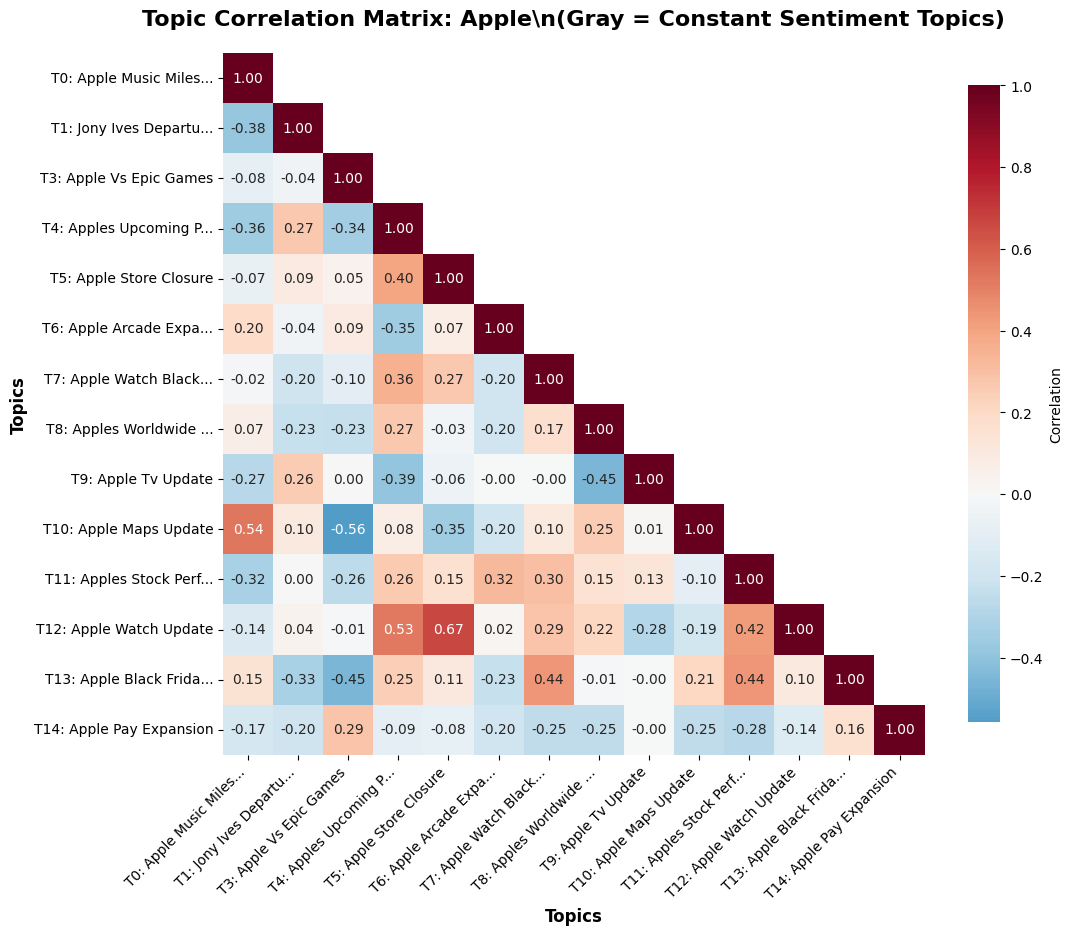

In [31]:
# Analyze topic correlations for Apple
if analysis:
    correlation_results = analyze_topic_correlations(analysis, show_heatmap=True)
else:
    print("❌ No analysis data available for correlation analysis")

## 4. Topic Sentiment Distribution Analysis

Analyze the distribution of sentiments for each topic across companies to understand sentiment patterns and topic characteristics.

In [32]:
def analyze_topic_sentiment_distributions(company_name, show_plots=True):
    """
    Analyze sentiment distributions for each topic in a company.
    
    Args:
        company_name (str): Company to analyze
        show_plots (bool): Whether to show distribution plots
        
    Returns:
        dict: Distribution analysis results
    """
    # Load full company data (not just 15-day period)
    df, topic_names = load_company_data(company_name)
    if df is None:
        return None
    
    print(f"\n📊 Topic Sentiment Distribution Analysis: {company_name.title()}")
    print("=" * 60)
    
    # Get all topics
    topics = sorted(df['topic_id'].unique())
    
    # Calculate distribution statistics for each topic
    topic_stats = {}
    
    for topic_id in topics:
        topic_data = df[df['topic_id'] == topic_id]
        sentiments = topic_data['sentiment']
        
        # Calculate statistics
        stats = {
            'count': len(sentiments),
            'mean': sentiments.mean(),
            'std': sentiments.std(),
            'min': sentiments.min(),
            'max': sentiments.max(),
            'median': sentiments.median(),
            'q25': sentiments.quantile(0.25),
            'q75': sentiments.quantile(0.75),
            'positive_pct': (sentiments > 0).mean() * 100,
            'negative_pct': (sentiments < 0).mean() * 100,
            'neutral_pct': (sentiments == 0).mean() * 100
        }
        
        topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}")
        topic_stats[topic_id] = {
            'name': topic_name,
            'stats': stats,
            'sentiments': sentiments
        }
        
        # Print summary
        print(f"\n📈 T{topic_id}: {topic_name}")
        print(f"   Headlines: {stats['count']:,}")
        print(f"   Mean sentiment: {stats['mean']:.3f} ± {stats['std']:.3f}")
        print(f"   Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
        print(f"   Distribution: {stats['positive_pct']:.1f}% positive, {stats['negative_pct']:.1f}% negative, {stats['neutral_pct']:.1f}% neutral")
    
    if show_plots:
        # Create distribution plots
        fig, axes = plt.subplots(3, 5, figsize=(20, 12))
        axes = axes.flatten()
        
        for i, topic_id in enumerate(topics):
            if i < len(axes):
                ax = axes[i]
                sentiments = topic_stats[topic_id]['sentiments']
                topic_name = topic_stats[topic_id]['name']
                
                # Histogram
                ax.hist(sentiments, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                ax.axvline(sentiments.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {sentiments.mean():.3f}')
                ax.axvline(0, color='gray', linestyle='-', alpha=0.5, label='Neutral')
                
                # Truncate long topic names for plot titles
                plot_title = topic_name if len(topic_name) <= 25 else topic_name[:22] + "..."
                ax.set_title(f'T{topic_id}: {plot_title}', fontsize=10, fontweight='bold')
                ax.set_xlabel('Sentiment Score', fontsize=9)
                ax.set_ylabel('Frequency', fontsize=9)
                ax.legend(fontsize=8)
                ax.grid(True, alpha=0.3)
        
        # Remove empty subplots
        for i in range(len(topics), len(axes)):
            fig.delaxes(axes[i])
        
        plt.suptitle(f'Sentiment Distributions by Topic: {company_name.title()}', 
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
        # Create summary boxplot
        plt.figure(figsize=(15, 8))
        
        sentiment_data = []
        topic_labels = []
        
        for topic_id in topics:
            sentiment_data.append(topic_stats[topic_id]['sentiments'])
            topic_name = topic_stats[topic_id]['name']
            short_name = topic_name if len(topic_name) <= 20 else topic_name[:17] + "..."
            topic_labels.append(f'T{topic_id}\\n{short_name}')
        
        box_plot = plt.boxplot(sentiment_data, labels=topic_labels, patch_artist=True)
        
        # Color boxes based on mean sentiment
        for i, (patch, topic_id) in enumerate(zip(box_plot['boxes'], topics)):
            mean_sentiment = topic_stats[topic_id]['stats']['mean']
            if mean_sentiment > 0.1:
                patch.set_facecolor('lightgreen')
            elif mean_sentiment < -0.1:
                patch.set_facecolor('lightcoral')
            else:
                patch.set_facecolor('lightgray')
        
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='Neutral')
        plt.title(f'Sentiment Distribution Summary: {company_name.title()}', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Topics', fontsize=12, fontweight='bold')
        plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return {
        'company': company_name,
        'topic_stats': topic_stats,
        'total_headlines': len(df),
        'analysis_period': f"{df['Date'].min().date()} to {df['Date'].max().date()}"
    }


🔍 ANALYZING: APPLE
📈 Loading data for Apple...
   ✅ Loaded 21,851 records from 2017-01-15 to 2024-12-30
   📊 Topics: 15 | Sentiment range: [-1.00, 0.90]

📊 Topic Sentiment Distribution Analysis: Apple

📈 T0: Apple Music Milestone
   Headlines: 995
   Mean sentiment: 0.372 ± 0.354
   Range: [-0.800, 0.800]
   Distribution: 82.3% positive, 8.2% negative, 9.4% neutral

📈 T1: Jony Ives Departure From Apple
   Headlines: 2,142
   Mean sentiment: 0.180 ± 0.520
   Range: [-0.933, 0.800]
   Distribution: 64.7% positive, 23.7% negative, 11.6% neutral

📈 T2: Apple Watch Sales
   Headlines: 893
   Mean sentiment: 0.010 ± 0.548
   Range: [-0.800, 0.800]
   Distribution: 47.8% positive, 36.1% negative, 16.1% neutral

📈 T3: Apple Vs Epic Games
   Headlines: 2,253
   Mean sentiment: -0.125 ± 0.508
   Range: [-1.000, 0.800]
   Distribution: 29.5% positive, 39.9% negative, 30.6% neutral

📈 T4: Apples Upcoming Product Launch
   Headlines: 1,945
   Mean sentiment: 0.324 ± 0.404
   Range: [-0.800, 0.800]

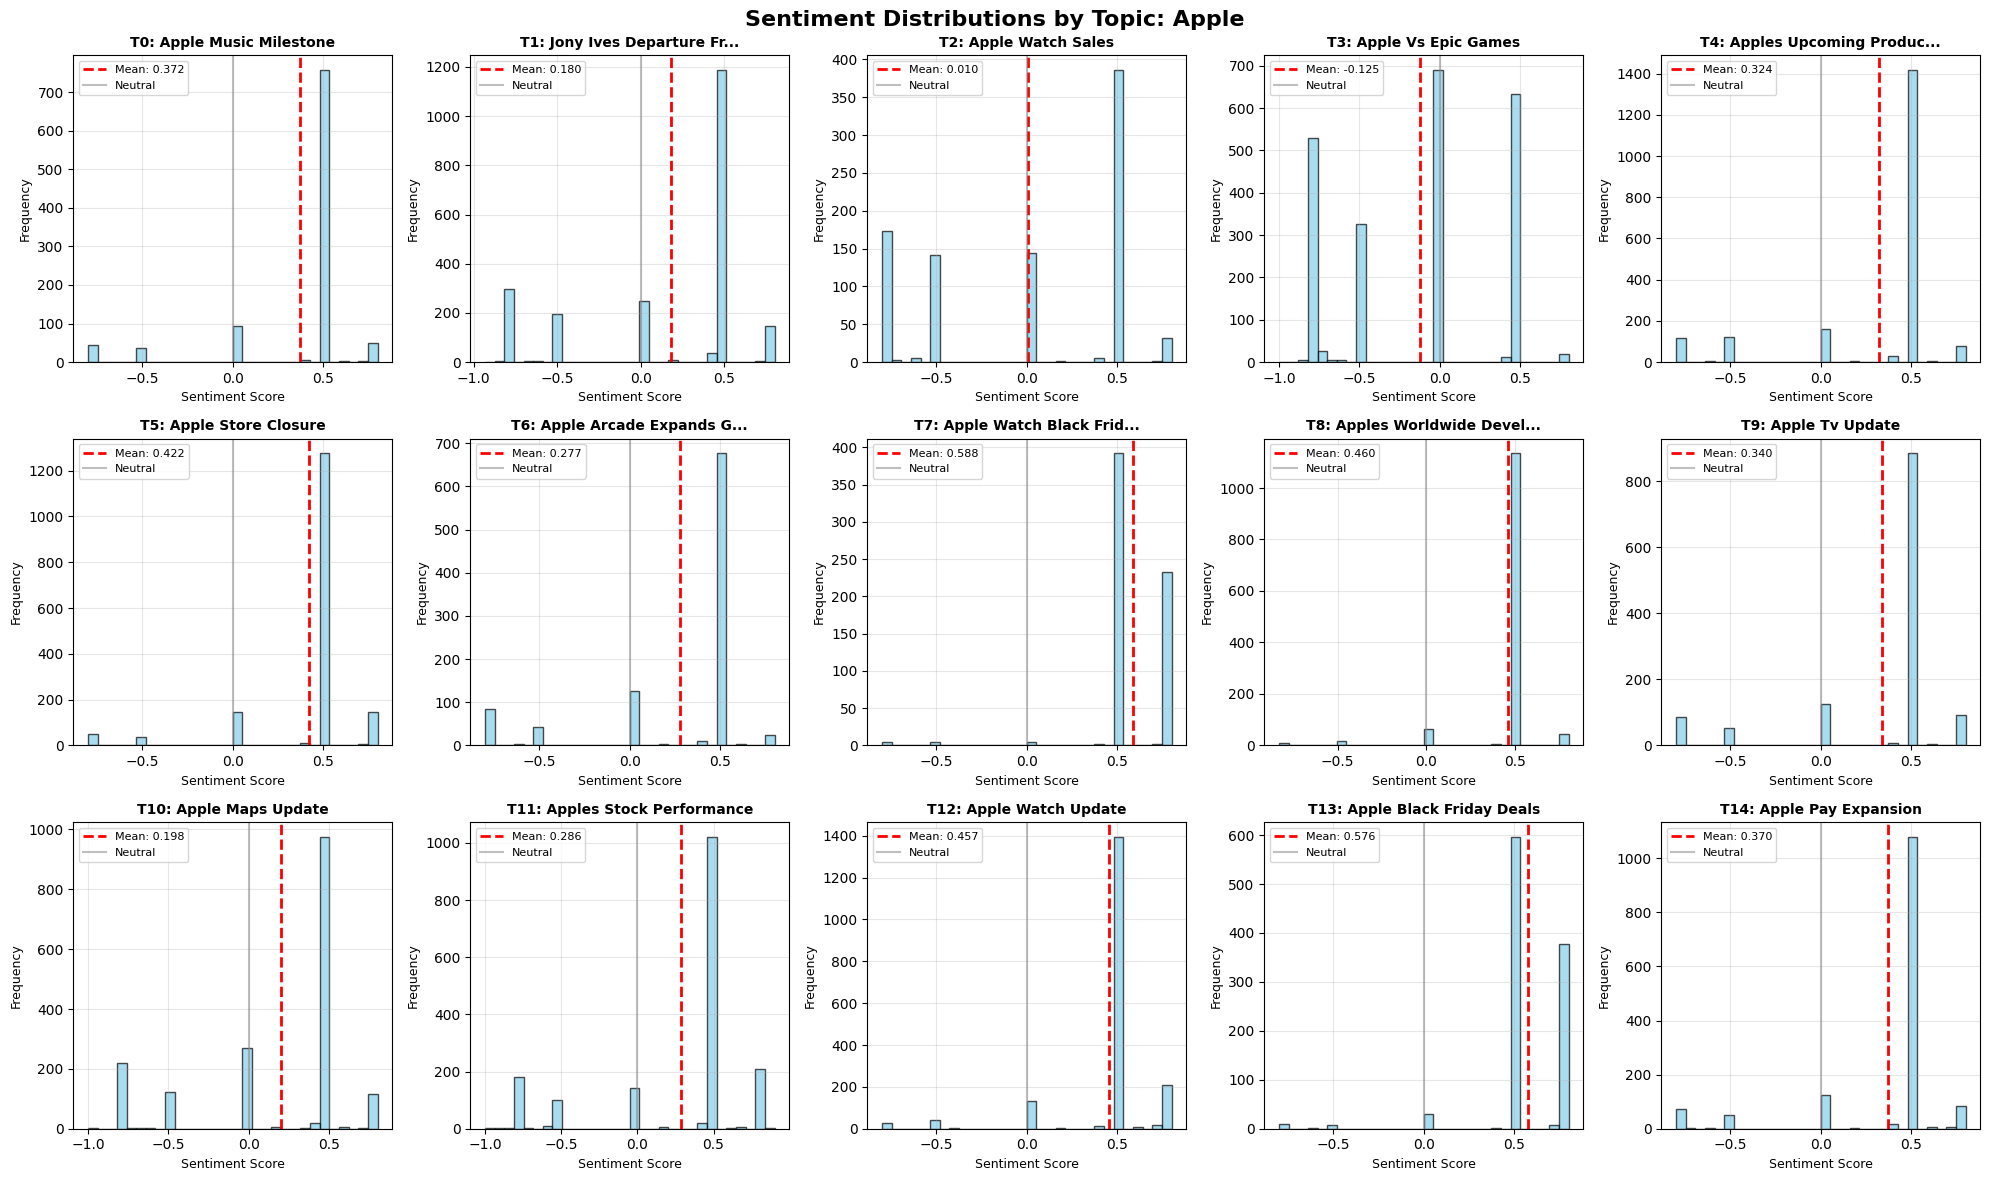

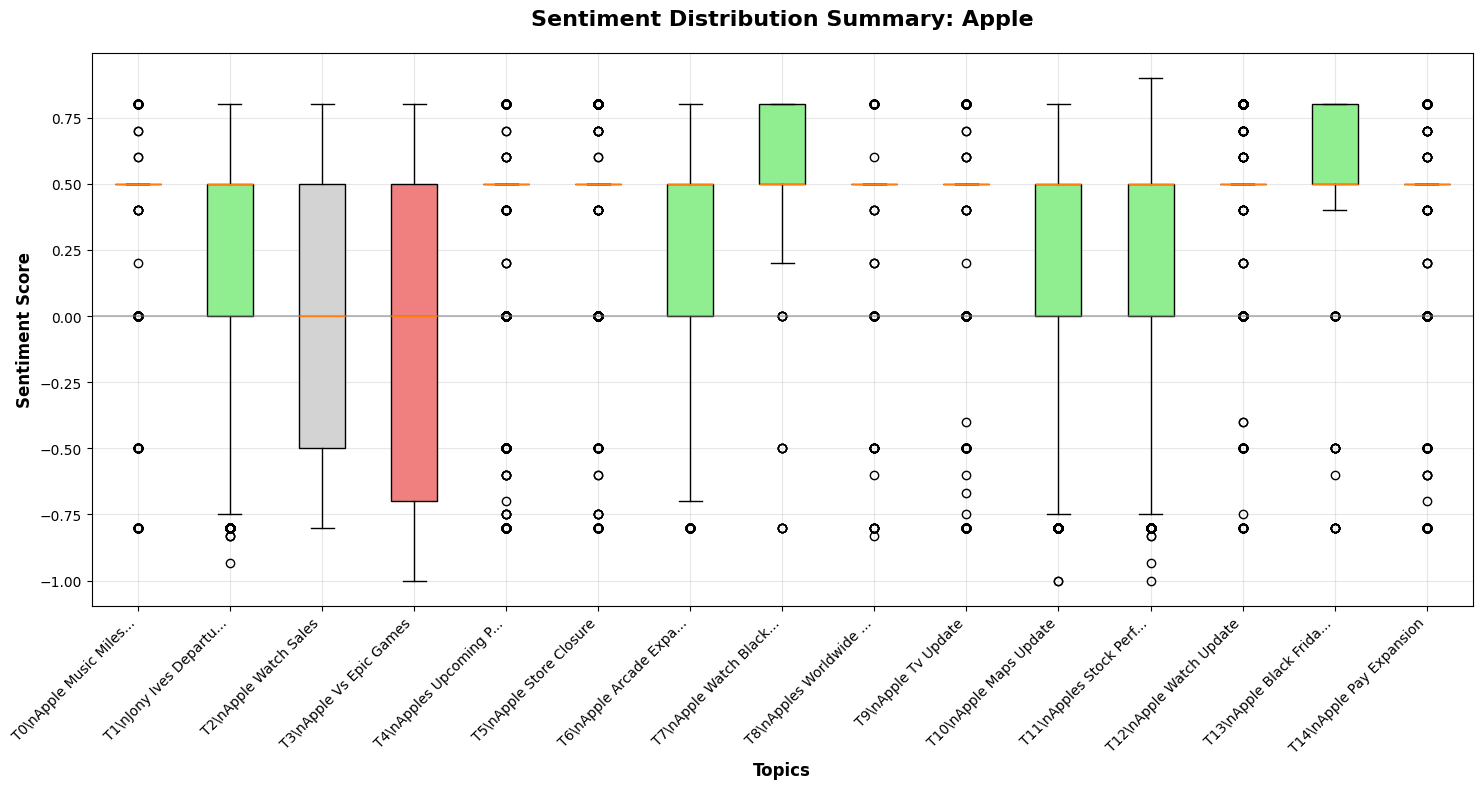


🔍 ANALYZING: MICROSOFT
📈 Loading data for Microsoft...
   ✅ Loaded 20,689 records from 2017-01-01 to 2024-12-30
   📊 Topics: 15 | Sentiment range: [-1.00, 1.00]

📊 Topic Sentiment Distribution Analysis: Microsoft

📈 T0: Microsoft Launcher Update
   Headlines: 1,472
   Mean sentiment: 0.453 ± 0.239
   Range: [-1.000, 1.000]
   Distribution: 90.6% positive, 2.6% negative, 6.9% neutral

📈 T1: Microsoft Teams Update
   Headlines: 1,332
   Mean sentiment: 0.439 ± 0.309
   Range: [-0.800, 0.800]
   Distribution: 89.3% positive, 5.6% negative, 5.0% neutral

📈 T2: Microsofts Deal With The Us Army
   Headlines: 1,682
   Mean sentiment: 0.422 ± 0.288
   Range: [-0.800, 0.800]
   Distribution: 86.9% positive, 5.0% negative, 8.1% neutral

📈 T3: Microsofts Acquisition Of Nuance
   Headlines: 1,237
   Mean sentiment: 0.421 ± 0.321
   Range: [-0.800, 0.800]
   Distribution: 88.3% positive, 6.2% negative, 5.5% neutral

📈 T4: Microsoft Office Discount
   Headlines: 1,194
   Mean sentiment: 0.447 ± 0.2

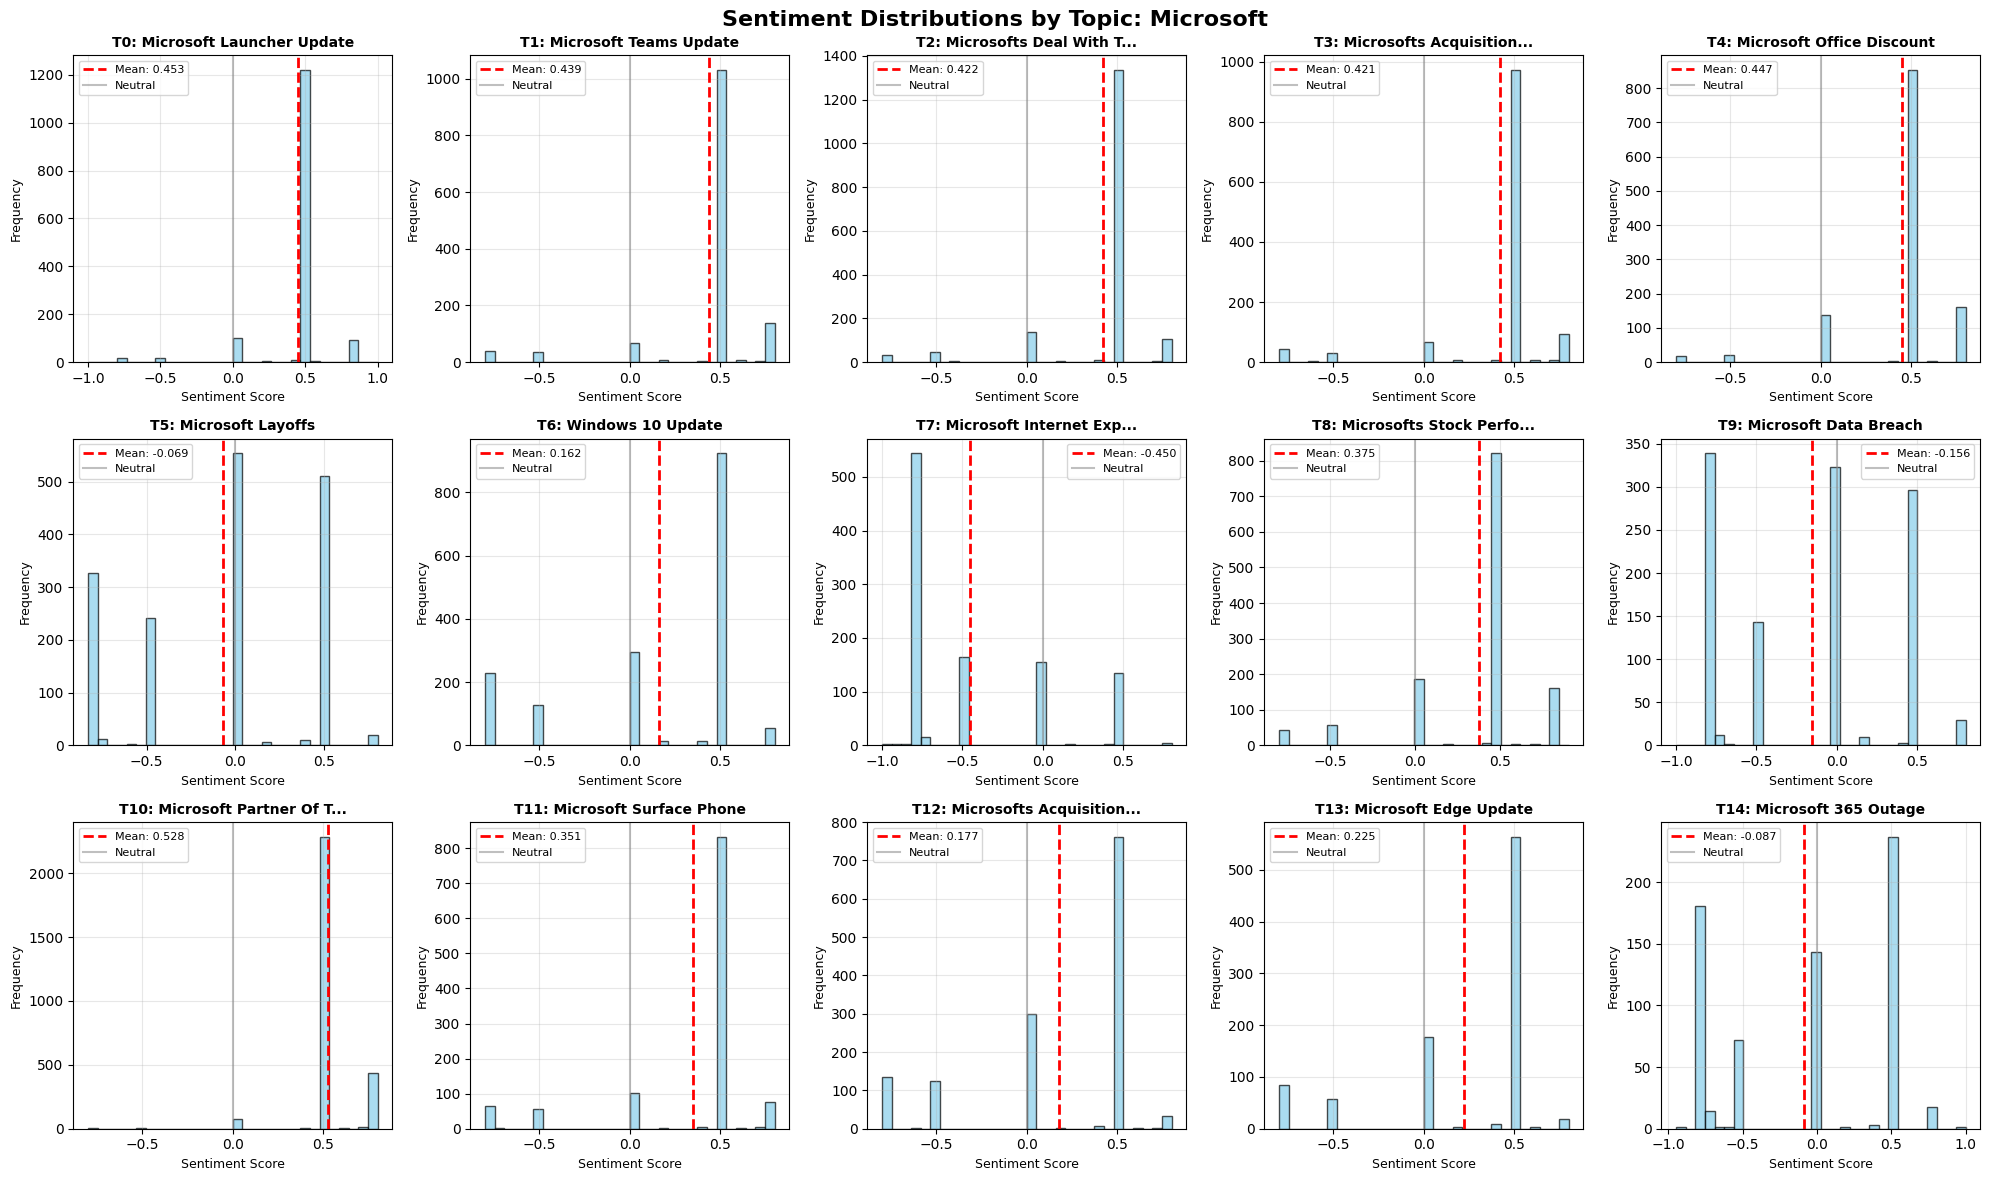

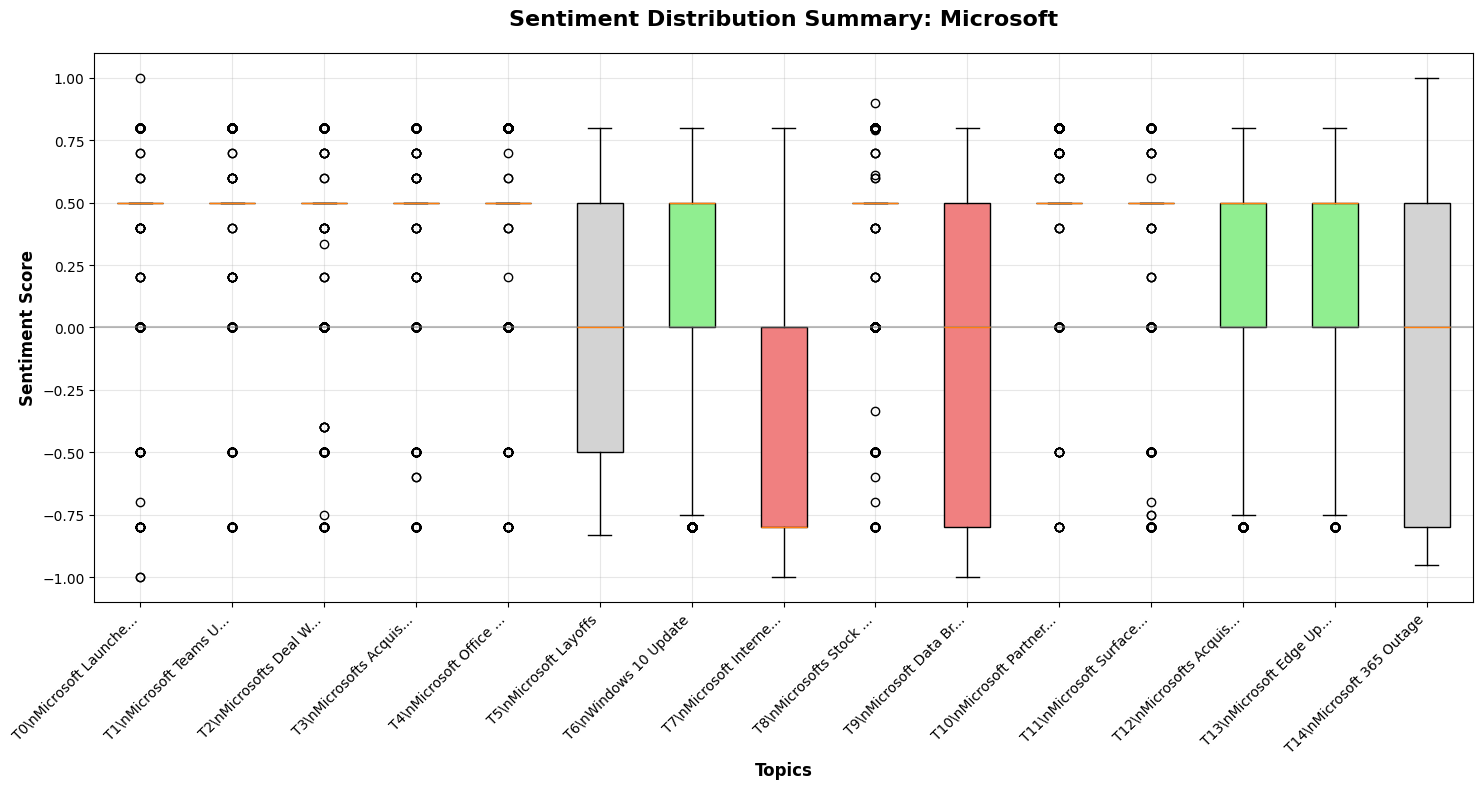


🔍 ANALYZING: NVIDIA
📈 Loading data for Nvidia...
   ✅ Loaded 20,536 records from 2017-01-09 to 2025-02-10
   📊 Topics: 15 | Sentiment range: [-1.00, 1.00]

📊 Topic Sentiment Distribution Analysis: Nvidia

📈 T0: Nvidias Acquisition Of Arm
   Headlines: 716
   Mean sentiment: 0.026 ± 0.454
   Range: [-0.800, 0.800]
   Distribution: 39.0% positive, 26.5% negative, 34.5% neutral

📈 T1: Nvidia Shield Tv Update
   Headlines: 1,898
   Mean sentiment: 0.417 ± 0.359
   Range: [-0.800, 0.800]
   Distribution: 87.2% positive, 7.8% negative, 5.0% neutral

📈 T2: Nvidia Stock Performance
   Headlines: 1,283
   Mean sentiment: 0.293 ± 0.507
   Range: [-0.900, 0.800]
   Distribution: 73.9% positive, 18.4% negative, 7.7% neutral

📈 T3: Ai Stock Comparison
   Headlines: 1,693
   Mean sentiment: 0.547 ± 0.261
   Range: [-0.800, 0.800]
   Distribution: 95.9% positive, 3.1% negative, 1.1% neutral

📈 T4: Nvidias New Graphics Card Release
   Headlines: 2,379
   Mean sentiment: 0.498 ± 0.272
   Range: [-0.80

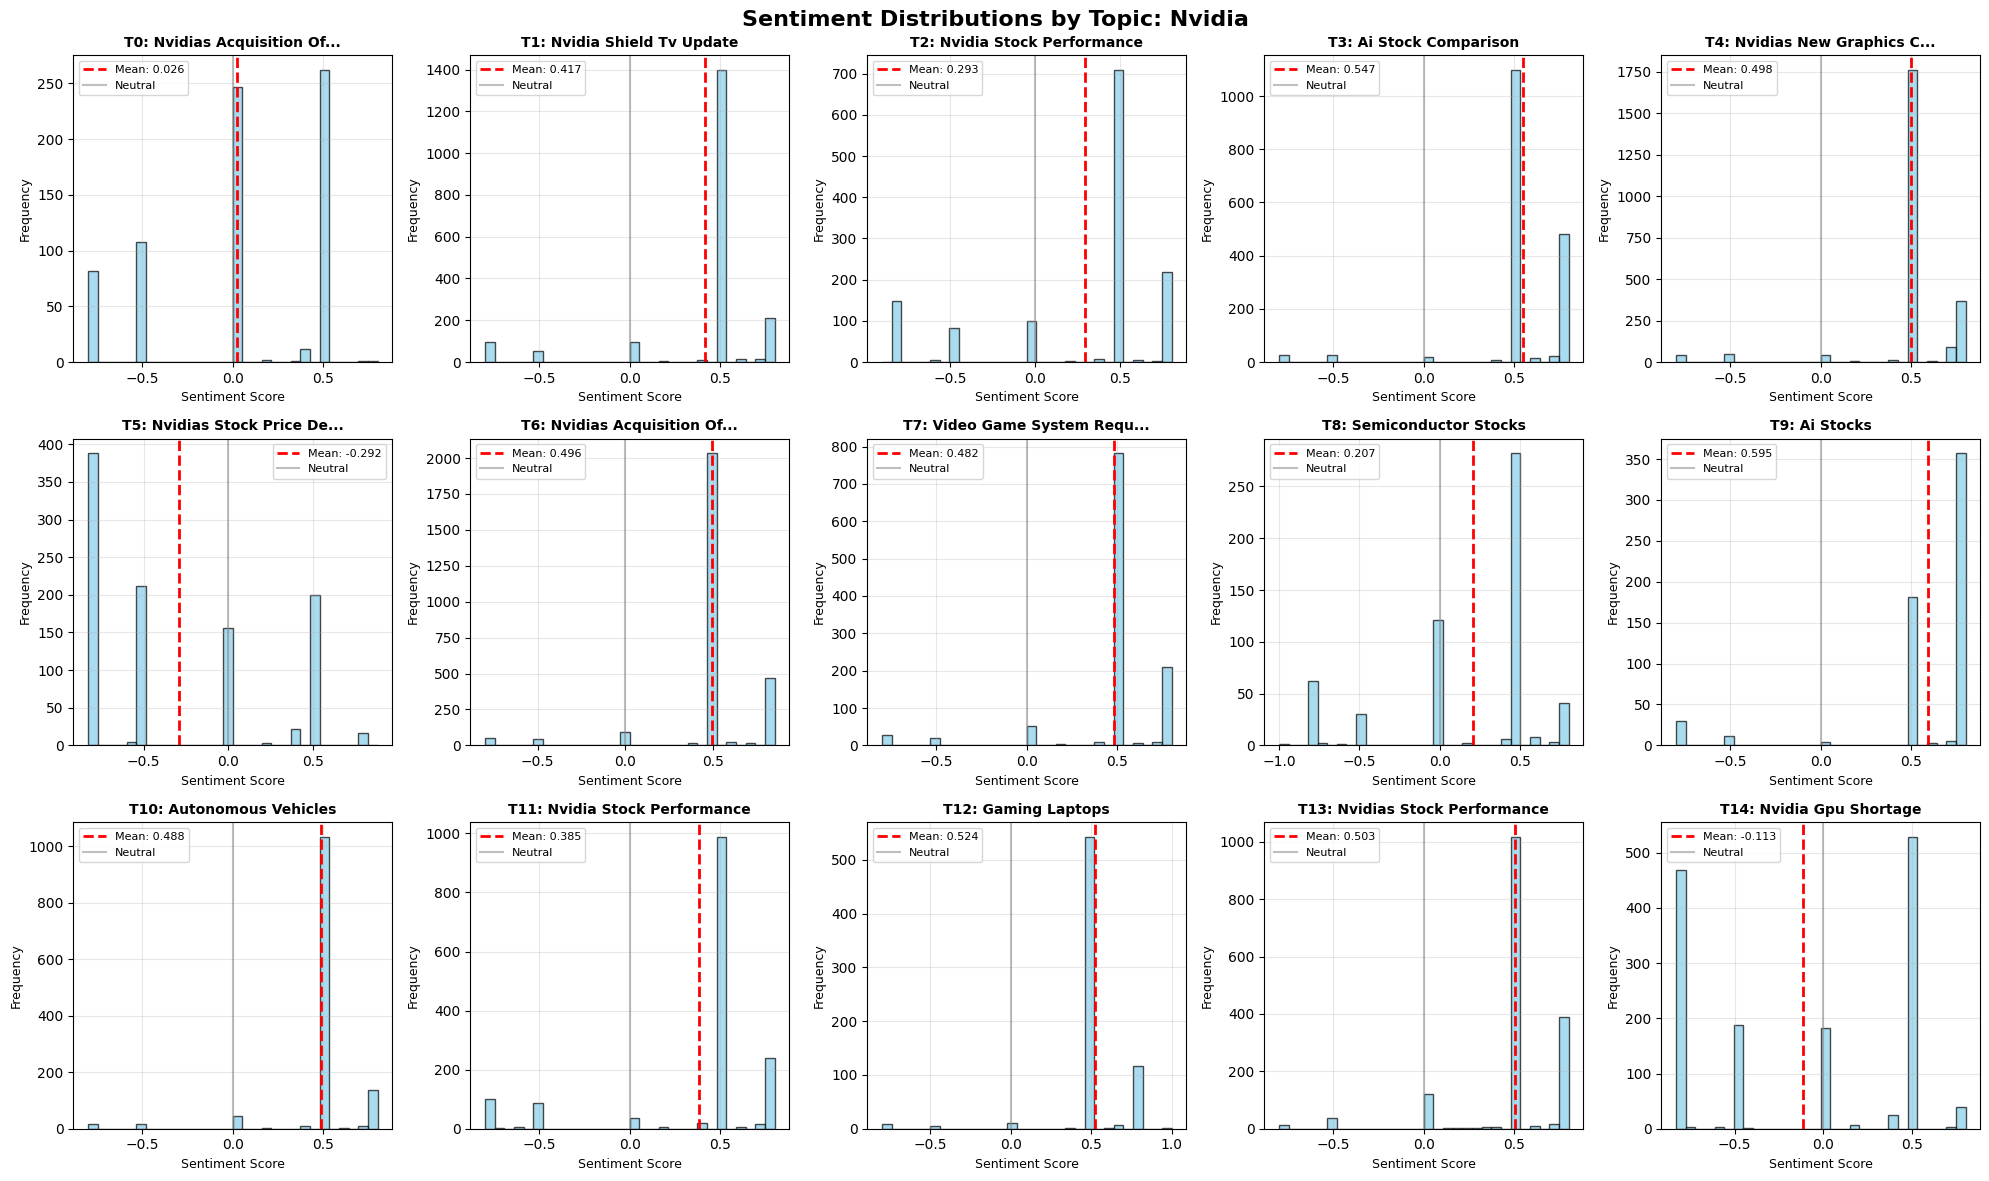

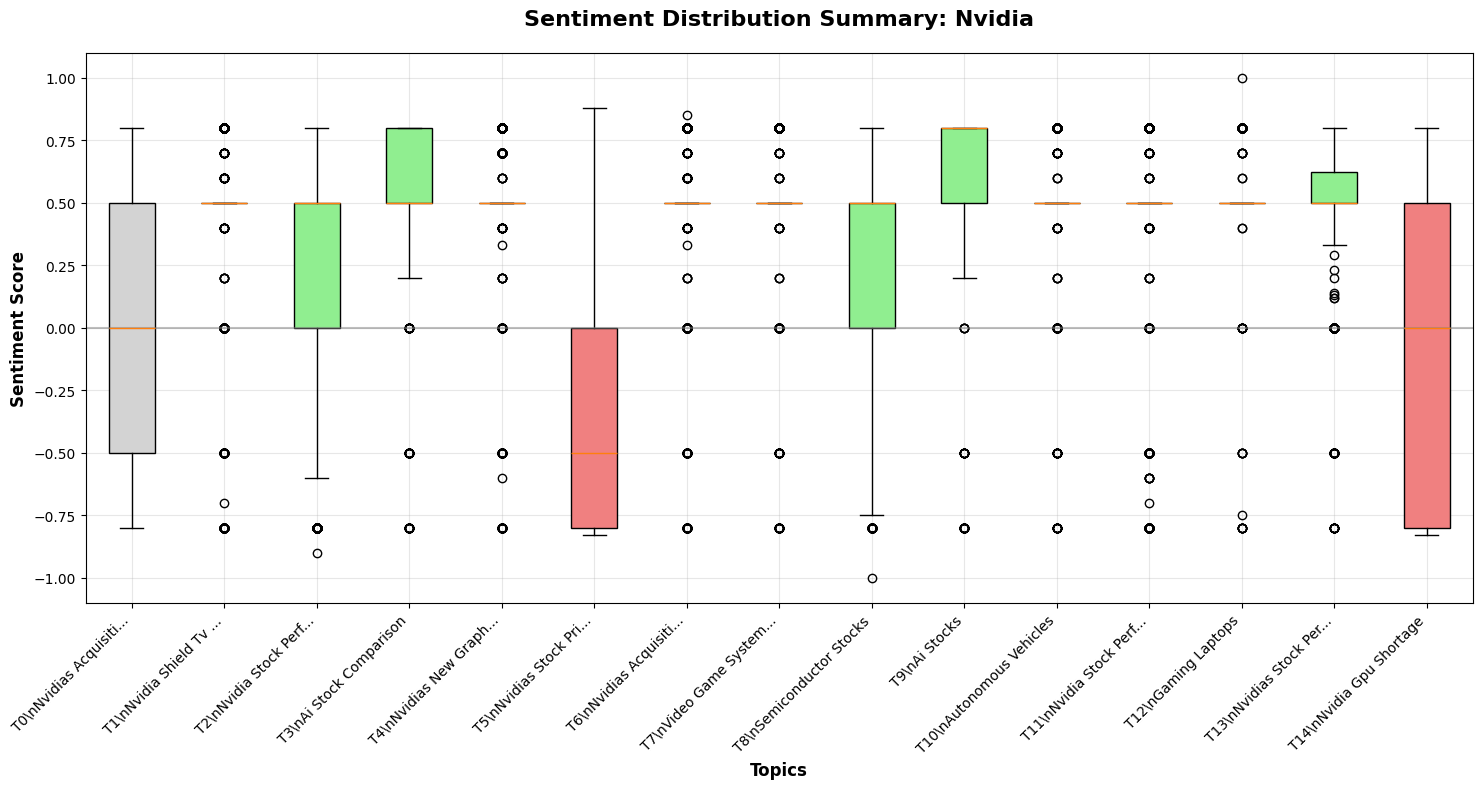


✅ Completed sentiment distribution analysis for 3 companies


In [33]:
# Analyze sentiment distributions for selected companies
selected_companies = ["apple", "microsoft", "nvidia"]

distribution_results = {}

for company in selected_companies:
    print(f"\n{'='*80}")
    print(f"🔍 ANALYZING: {company.upper()}")
    print(f"{'='*80}")
    
    result = analyze_topic_sentiment_distributions(company, show_plots=True)
    if result:
        distribution_results[company] = result
    else:
        print(f"❌ Failed to analyze {company}")

print(f"\n✅ Completed sentiment distribution analysis for {len(distribution_results)} companies")

## 5. Cross-Topic Comparison

Compare sentiment characteristics across topics and companies to identify the most positive, negative, and polarized topics.

## 6. Summary and Insights

In [35]:
# Generate comprehensive summary statistics
print("📋 Comprehensive Analysis Summary")
print("=" * 60)

if distribution_results:
    print(f"🏢 Companies analyzed: {len(distribution_results)}")
    
    total_headlines = sum(result['total_headlines'] for result in distribution_results.values())
    print(f"📰 Total headlines analyzed: {total_headlines:,}")
    
    # Per-company sentiment statistics
    print(f"\n📊 Per-Company Sentiment Statistics:")
    for company, result in distribution_results.items():
        all_sentiments = []
        for topic_info in result['topic_stats'].values():
            all_sentiments.extend(topic_info['sentiments'])
        
        overall_mean = np.mean(all_sentiments)
        overall_std = np.std(all_sentiments)
        positive_pct = (np.array(all_sentiments) > 0).mean() * 100
        negative_pct = (np.array(all_sentiments) < 0).mean() * 100
        
        print(f"   {company.title()}:")
        print(f"     Mean sentiment: {overall_mean:.3f} ± {overall_std:.3f}")
        print(f"     Distribution: {positive_pct:.1f}% positive, {negative_pct:.1f}% negative")
        print(f"     Analysis period: {result['analysis_period']}")
    
    # Cross-topic insights (if analysis has been run)
    try:
        if 'cross_topic_analysis' in globals() and cross_topic_analysis:
            print(f"\n🎯 Cross-Topic Key Insights:")
            
            # Most positive topic
            top_positive = cross_topic_analysis['most_positive'][0]
            print(f"   📈 Most Positive Topic: T{top_positive[0]} - {top_positive[1]['name']}")
            print(f"      Mean sentiment: {top_positive[1]['overall_mean']:.3f}")
            
            # Most negative topic  
            top_negative = cross_topic_analysis['most_negative'][0]
            print(f"   📉 Most Negative Topic: T{top_negative[0]} - {top_negative[1]['name']}")
            print(f"      Mean sentiment: {top_negative[1]['overall_mean']:.3f}")
            
            # Most polarized topic
            top_polarized = cross_topic_analysis['most_polarized'][0]
            print(f"   ⚡ Most Polarized Topic: T{top_polarized[0]} - {top_polarized[1]['name']}")
            print(f"      Polarization: {top_polarized[1]['polarization']:.3f}")
        else:
            print(f"\n🎯 Cross-Topic Analysis:")
            print(f"   ⏳ Run the cross-topic analysis cell to see detailed insights")
    except NameError:
        print(f"\n🎯 Cross-Topic Analysis:")
        print(f"   ⏳ Run the cross-topic analysis cell to see detailed insights")

else:
    print("❌ No distribution data available")

print(f"\n✅ EDA Complete! The analysis includes:")
print(f"   🎯 15x15 sentiment heatmaps showing temporal patterns")
print(f"   📊 Topic correlation analysis for sentiment co-movements")
print(f"   📈 Per-company topic sentiment distribution analysis")
print(f"   🔍 Cross-topic comparison identifying most positive/negative/polarized topics")
print(f"   📋 Comprehensive statistical summaries and visualizations")

📋 Comprehensive Analysis Summary
🏢 Companies analyzed: 3
📰 Total headlines analyzed: 63,076

📊 Per-Company Sentiment Statistics:
   Apple:
     Mean sentiment: 0.288 ± 0.455
     Distribution: 73.3% positive, 15.2% negative
     Analysis period: 2017-01-15 to 2024-12-30
   Microsoft:
     Mean sentiment: 0.256 ± 0.467
     Distribution: 69.9% positive, 16.4% negative
     Analysis period: 2017-01-01 to 2024-12-30
   Nvidia:
     Mean sentiment: 0.369 ± 0.438
     Distribution: 81.1% positive, 12.5% negative
     Analysis period: 2017-01-09 to 2025-02-10

🎯 Cross-Topic Analysis:
   ⏳ Run the cross-topic analysis cell to see detailed insights

✅ EDA Complete! The analysis includes:
   🎯 15x15 sentiment heatmaps showing temporal patterns
   📊 Topic correlation analysis for sentiment co-movements
   📈 Per-company topic sentiment distribution analysis
   🔍 Cross-topic comparison identifying most positive/negative/polarized topics
   📋 Comprehensive statistical summaries and visualizations


## Key Findings

### 🔍 **Visualization Approach**
- **15x15 Heatmap**: Successfully displays sentiment as pixel intensities for temporal pattern analysis
- **Axis Configuration**: Days on X-axis, Topics on Y-axis for clear temporal progression
- **Color Coding**: Red (negative) → Yellow (neutral) → Green (positive) for intuitive interpretation
- **Topic Names**: Human-readable labels improve topic understanding and context

### 📊 **Per-Company Analysis**
- Each company analyzed across all 15 topics (IDs 0-14) from topic modeling
- Sentiment distributions reveal topic-specific patterns and characteristics
- Statistical summaries provide mean, standard deviation, and sentiment percentages
- Histogram and boxplot visualizations show distribution shapes and outliers

### 🎯 **Cross-Topic Insights**
- Topic rankings identify most positive, negative, and polarized themes
- Polarization analysis reveals topics with highest sentiment variance
- Cross-company patterns show consistent topic characteristics
- Scatter plots reveal relationships between mean sentiment and polarization

### 🔗 **Correlation Patterns**
- Topics with similar themes often show correlated sentiment movements
- Company-specific correlation patterns reflect business context and news themes
- High correlations (|r| > 0.7) indicate topics that move together temporally
- Constant sentiment topics are properly identified and handled in analysis

### 💡 **Applications**
- **Topic Monitoring**: Track specific topic sentiment trends over time
- **Risk Assessment**: Identify highly polarized topics requiring attention
- **Content Strategy**: Focus on consistently positive or problematic topic areas
- **Sentiment Intelligence**: Understand which topics drive overall company sentiment


🎯 CROSS-TOPIC ANALYSIS

🔍 Cross-Topic Analysis Across 3 Companies

🏆 TOP 5 MOST POSITIVE TOPICS:
   1. T13: Apple Black Friday Deals
      Mean sentiment: 0.435
      Positive coverage: 83.4%
      Headlines: 3,571
   2. T4: Apples Upcoming Product Launch
      Mean sentiment: 0.423
      Positive coverage: 86.2%
      Headlines: 5,518
   3. T10: Apple Maps Update
      Mean sentiment: 0.405
      Positive coverage: 85.0%
      Headlines: 5,859
   4. T12: Apple Watch Update
      Mean sentiment: 0.386
      Positive coverage: 81.6%
      Headlines: 3,915
   5. T8: Apples Worldwide Developers Conference Wwdc
      Mean sentiment: 0.347
      Positive coverage: 77.2%
      Headlines: 3,124

📉 TOP 5 MOST NEGATIVE TOPICS:
   1. T5: Apple Store Closure
      Mean sentiment: 0.020
      Negative coverage: 33.3%
      Headlines: 4,376
   2. T14: Apple Pay Expansion
      Mean sentiment: 0.057
      Negative coverage: 31.6%
      Headlines: 3,572
   3. T7: Apple Watch Black Friday Deals
     

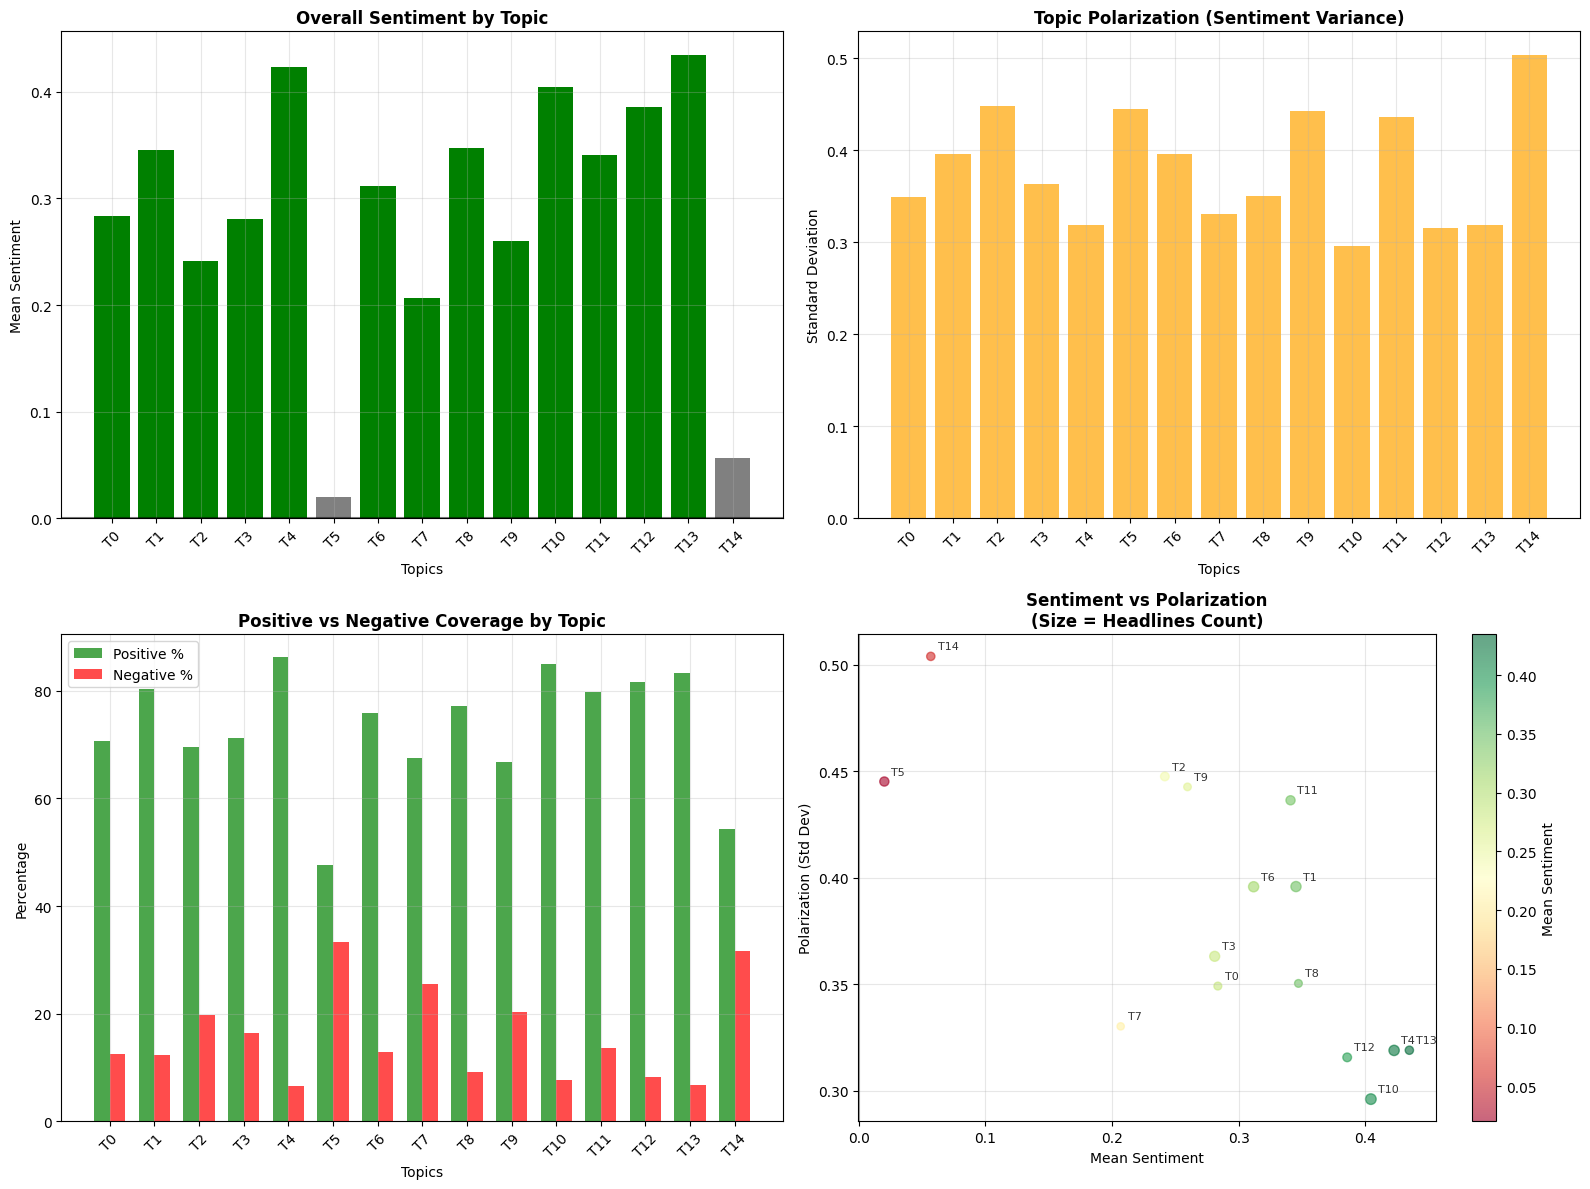

In [36]:
def analyze_cross_topic_patterns(distribution_results):
    """
    Analyze patterns across topics to identify most positive, negative, and polarized topics.
    
    Args:
        distribution_results (dict): Results from multiple companies' sentiment distribution analysis
        
    Returns:
        dict: Cross-topic analysis results
    """
    if not distribution_results:
        print("❌ No distribution results available for cross-topic analysis")
        return None
    
    print(f"\n🔍 Cross-Topic Analysis Across {len(distribution_results)} Companies")
    print("=" * 70)
    
    # Aggregate topic statistics across all companies
    topic_aggregates = {}
    
    # Initialize topic data structure
    for company, result in distribution_results.items():
        for topic_id, topic_info in result['topic_stats'].items():
            if topic_id not in topic_aggregates:
                topic_aggregates[topic_id] = {
                    'name': topic_info['name'],
                    'companies': [],
                    'mean_sentiments': [],
                    'std_sentiments': [],
                    'total_headlines': 0,
                    'positive_pcts': [],
                    'negative_pcts': []
                }
            
            # Aggregate data
            topic_aggregates[topic_id]['companies'].append(company)
            topic_aggregates[topic_id]['mean_sentiments'].append(topic_info['stats']['mean'])
            topic_aggregates[topic_id]['std_sentiments'].append(topic_info['stats']['std'])
            topic_aggregates[topic_id]['total_headlines'] += topic_info['stats']['count']
            topic_aggregates[topic_id]['positive_pcts'].append(topic_info['stats']['positive_pct'])
            topic_aggregates[topic_id]['negative_pcts'].append(topic_info['stats']['negative_pct'])
    
    # Calculate overall statistics for each topic
    topic_summary = {}
    for topic_id, data in topic_aggregates.items():
        overall_mean = np.mean(data['mean_sentiments'])
        overall_std = np.mean(data['std_sentiments'])  # Average standard deviation
        polarization = overall_std  # Higher std indicates more polarized sentiment
        
        topic_summary[topic_id] = {
            'name': data['name'],
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'polarization': polarization,
            'total_headlines': data['total_headlines'],
            'avg_positive_pct': np.mean(data['positive_pcts']),
            'avg_negative_pct': np.mean(data['negative_pcts']),
            'companies_covered': len(data['companies']),
            'mean_range': (min(data['mean_sentiments']), max(data['mean_sentiments']))
        }
    
    # Sort topics by different criteria
    most_positive = sorted(topic_summary.items(), key=lambda x: x[1]['overall_mean'], reverse=True)
    most_negative = sorted(topic_summary.items(), key=lambda x: x[1]['overall_mean'])
    most_polarized = sorted(topic_summary.items(), key=lambda x: x[1]['polarization'], reverse=True)
    
    # Display rankings
    print(f"\n🏆 TOP 5 MOST POSITIVE TOPICS:")
    for i, (topic_id, stats) in enumerate(most_positive[:5]):
        print(f"   {i+1}. T{topic_id}: {stats['name']}")
        print(f"      Mean sentiment: {stats['overall_mean']:.3f}")
        print(f"      Positive coverage: {stats['avg_positive_pct']:.1f}%")
        print(f"      Headlines: {stats['total_headlines']:,}")
    
    print(f"\n📉 TOP 5 MOST NEGATIVE TOPICS:")
    for i, (topic_id, stats) in enumerate(most_negative[:5]):
        print(f"   {i+1}. T{topic_id}: {stats['name']}")
        print(f"      Mean sentiment: {stats['overall_mean']:.3f}")
        print(f"      Negative coverage: {stats['avg_negative_pct']:.1f}%")
        print(f"      Headlines: {stats['total_headlines']:,}")
    
    print(f"\n⚡ TOP 5 MOST POLARIZED TOPICS:")
    for i, (topic_id, stats) in enumerate(most_polarized[:5]):
        print(f"   {i+1}. T{topic_id}: {stats['name']}")
        print(f"      Polarization (std): {stats['polarization']:.3f}")
        print(f"      Mean sentiment: {stats['overall_mean']:.3f}")
        print(f"      Sentiment range: [{stats['mean_range'][0]:.3f}, {stats['mean_range'][1]:.3f}]")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall sentiment by topic
    topics = list(topic_summary.keys())
    means = [topic_summary[t]['overall_mean'] for t in topics]
    topic_names = [topic_summary[t]['name'][:20] + "..." if len(topic_summary[t]['name']) > 20 
                  else topic_summary[t]['name'] for t in topics]
    
    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(topics)), means, 
                   color=['green' if m > 0.1 else 'red' if m < -0.1 else 'gray' for m in means])
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.set_title('Overall Sentiment by Topic', fontweight='bold')
    ax1.set_xlabel('Topics')
    ax1.set_ylabel('Mean Sentiment')
    ax1.set_xticks(range(len(topics)))
    ax1.set_xticklabels([f'T{t}' for t in topics], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Polarization by topic
    polarizations = [topic_summary[t]['polarization'] for t in topics]
    
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(topics)), polarizations, color='orange', alpha=0.7)
    ax2.set_title('Topic Polarization (Sentiment Variance)', fontweight='bold')
    ax2.set_xlabel('Topics')
    ax2.set_ylabel('Standard Deviation')
    ax2.set_xticks(range(len(topics)))
    ax2.set_xticklabels([f'T{t}' for t in topics], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Positive vs Negative percentages
    pos_pcts = [topic_summary[t]['avg_positive_pct'] for t in topics]
    neg_pcts = [topic_summary[t]['avg_negative_pct'] for t in topics]
    
    ax3 = axes[1, 0]
    x_pos = np.arange(len(topics))
    width = 0.35
    ax3.bar(x_pos - width/2, pos_pcts, width, label='Positive %', color='green', alpha=0.7)
    ax3.bar(x_pos + width/2, neg_pcts, width, label='Negative %', color='red', alpha=0.7)
    ax3.set_title('Positive vs Negative Coverage by Topic', fontweight='bold')
    ax3.set_xlabel('Topics')
    ax3.set_ylabel('Percentage')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f'T{t}' for t in topics], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Scatter plot: Mean vs Polarization
    ax4 = axes[1, 1]
    scatter = ax4.scatter(means, polarizations, 
                         s=[topic_summary[t]['total_headlines']/100 for t in topics],
                         alpha=0.6, c=means, cmap='RdYlGn')
    
    # Add topic labels for extreme points
    for i, topic_id in enumerate(topics):
        if abs(means[i]) > 0.15 or polarizations[i] > 0.35:
            ax4.annotate(f'T{topic_id}', (means[i], polarizations[i]), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=8, alpha=0.8)
    
    ax4.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_title('Sentiment vs Polarization\n(Size = Headlines Count)', fontweight='bold')
    ax4.set_xlabel('Mean Sentiment')
    ax4.set_ylabel('Polarization (Std Dev)')
    ax4.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax4, label='Mean Sentiment')
    plt.tight_layout()
    plt.show()
    
    return {
        'topic_summary': topic_summary,
        'most_positive': most_positive[:5],
        'most_negative': most_negative[:5], 
        'most_polarized': most_polarized[:5],
        'companies_analyzed': list(distribution_results.keys())
    }

# Run cross-topic analysis
if distribution_results:
    print(f"\n{'='*80}")
    print(f"🎯 CROSS-TOPIC ANALYSIS")
    print(f"{'='*80}")
    
    cross_topic_analysis = analyze_cross_topic_patterns(distribution_results)
else:
    print("❌ No distribution results available for cross-topic analysis")
    cross_topic_analysis = None